In [15]:
contents

{'title': 'Element test',
 'mesh': {'mesh': 'mesh.txt',
  'entity_sets': 'entity_sets.json',
  'cell_type': 'ED2Q4',
  'isoparametric': False,
  'io_type': 'Ascii2D',
  'node_type': 'N2D',
  'boundary_conditions': {'velocity_constraints': [{'nset_id': 0,
     'dir': 1,
     'velocity': 0.0},
    {'nset_id': 1, 'dir': 1, 'velocity': -0.01}]}},
 'particles': [{'generator': {'check_duplicates': True,
    'location': 'particles.txt',
    'io_type': 'Ascii2D',
    'pset_id': 0,
    'particle_type': 'P2D',
    'material_id': 0,
    'type': 'file'}}],
 'materials': [{'id': 0,
   'type': 'LinearElastic2D',
   'density': 1,
   'youngs_modulus': 1000,
   'poisson_ratio': 0.0}],
 'external_loading_conditions': {'gravity': [0, 0]},
 'analysis': {'type': 'MPMExplicit2D',
  'stress_update': 'usf',
  'dt': 0.01,
  'uuid': 'uniaxial-stress-2d-usf',
  'nsteps': 10,
  'resume': {'resume': False, 'uuid': 'uniaxial-stress-2d-usf', 'step': 5}},
 'post_processing': {'path': 'results/', 'output_steps': 1}}

In [3]:
import json
import jax.numpy as jnp
from jax import grad, jit, vmap, lax
import jax.scipy as jsp
import jax.scipy.optimize as jsp_opt
import optax 
import jaxopt
from jaxopt import ScipyBoundedMinimize
import matplotlib.pyplot as plt
import jax
from functools import partial

def jdprint(obj, string = ""):
    jax.debug.print(string+': {x}', x=obj)

@jit
def mpm(E):

    json_file_path = "../mpm-benchmarks/2d/plate_with_hole/cartesian/"


    with open(json_file_path + 'mpm.json', 'r') as j:
        contents = json.loads(j.read())


    # mesh
    ndim = int(contents['mesh']['node_type'][-2])
    mesh_file = contents['mesh']['mesh']
    with open(json_file_path + mesh_file, 'r') as file:
        lines = file.readlines()
        info_line = 0
        nnodes, nelements = map(int, lines[info_line].split())
        x_n = jnp.zeros((nnodes, 2))
        elements = []
        for line, i in zip(lines[info_line+1:info_line+nnodes+1], jnp.arange(nnodes)):
            x, y = map(float, line.split())
            x_n = x_n.at[i].set((x, y))
        for line, i in zip(lines[info_line+nnodes+1:], jnp.arange(nelements)):
            n1, n2, n3, n4 = map(int, line.split())
            elements.append([n1, n2, n3, n4])

    # particles
    particles = contents['particles']
    n_particles_types = len(particles)
    particles_loc_files = []
    for i in particles:
        particles_loc_files.append(i['generator']['location'])

    with open(json_file_path + particles_loc_files[0], 'r') as file:
        lines = file.readlines()
        nparticles = int(lines[0])
        x_p = jnp.zeros((nparticles, 2))
        for line, i in zip(lines[1:], jnp.arange(nparticles)):
            x, y = map(float, line.split())
            x_p = x_p.at[i].set((x, y))

    # entity sets
    entity_sets_file = contents['mesh']['entity_sets']

    with open(json_file_path + entity_sets_file, 'r') as j:
        entity_sets = json.loads(j.read())

    node_sets = []
    for i in entity_sets['node_sets']:
        node_sets.append(i['set'])

    # constraints
    boundary_conditions = contents['mesh']['boundary_conditions']
    try: 
        velocity_constraints = boundary_conditions['velocity_constraints']
        velocity_constraints_bool = True
    except: 
        velocity_constraints_bool = False
    
    # analysis
    dt = contents['analysis']['dt']
    nsteps = contents['analysis']['nsteps']

    # materials
    materials = contents['materials']
    n_materials = len(materials)
    rho = materials[0]['density']
    poisson_ratio = materials[0]['poisson_ratio']
    # for i in jnp.arange(n_materials):
    #     rho = rho.at[i].set(materials[i]['density'])
    #     E = E.at[i].set(materials[i]['youngs_modulus'])
    #     poisson_ratio = poisson_ratio.at[i].set(materials[i]['poisson_ratio'])




    # nsteps
    nsteps = 10
    

    # Domain length
    Lx = jnp.max(x_n[:, 0]) - jnp.min(x_n[:, 0])
    Ly = jnp.max(x_n[:, 1]) - jnp.min(x_n[:, 1])


    # Material properties
    # rho = 1 # density
    # E = E # young's modulus
    # poisson_ratio = 0 # poisson ratio
    bulk_modulus = E / (3 * (1 - 2 * poisson_ratio))
    G = E / (2 * (1 + poisson_ratio))
    a1 = bulk_modulus + (4 / 3) * G
    a2 = bulk_modulus - (2 / 3) * G


    # Computational grid
    nelementsx = 1
    nelementsy = 1
    
    dx = Lx / nelementsx
    dy = Ly / nelementsy
    

    # Id of the particle in the central element
    pmid = nparticles// 2  # Midpoint of the material points
    
    # Material point properties
    vol_p      = jnp.ones(nparticles) * Lx * Ly / nparticles       # volume
    mass_p     = vol_p * rho                                # mass
    vel_p     = jnp.zeros((nparticles, 2))                  # velocity
    
    stress_p   = jnp.zeros((nparticles, 3))                 # stress

    vel_p_vec = jnp.zeros((nparticles, ndim))
    x_p_vec = jnp.zeros((nparticles, ndim))



    # Time steps and duration
    # dt_crit = jnp.max(jnp.array([dx / c, dy / c]))
    dt = 0.01
    
    # results
    # tt = jnp.zeros(nsteps)
    vt = jnp.zeros((nsteps, 2))
    xt = jnp.zeros((nsteps, 2))
    sigmat = jnp.zeros((nsteps, nparticles, 3))

    def get_particles_in_elements(elements, x_n, x_p):
        # Helper function to check if a point is inside a quadrilateral
        def is_inside_element(point, element_coords):
            x, y = point
            x1, y1 = element_coords[0]
            x2, y2 = element_coords[1]
            x3, y3 = element_coords[2]
            x4, y4 = element_coords[3]

            # Check if the point is inside the convex quadrilateral using barycentric coordinates
            b1 = (x - x2) * (y1 - y2) - (x1 - x2) * (y - y2)
            b2 = (x - x3) * (y2 - y3) - (x2 - x3) * (y - y3)
            b3 = (x - x4) * (y3 - y4) - (x3 - x4) * (y - y4)
            b4 = (x - x1) * (y4 - y1) - (x4 - x1) * (y - y1)

            def true_fun_is_inside():
                return 1
            
            def false_fun_is_inside():
                return 0

            greater_than_0 = jax.lax.cond(jnp.min(jnp.array([b1, b2, b3, b4])) >= 0, true_fun_is_inside, false_fun_is_inside)
            less_than_0 = jax.lax.cond(jnp.max(jnp.array([b1, b2, b3, b4])) <= 0, true_fun_is_inside, false_fun_is_inside)

            #  jnp.min(jnp.array([b1, b2, b3, b4]))
            # (b1 >= 0 and b2 >= 0 and b3 >= 0 and b4 >= 0) or (b1 <= 0 and b2 <= 0 and b3 <= 0 and b4 <= 0)
            return jax.lax.cond(greater_than_0 + less_than_0 > 0, 
                                true_fun_is_inside,
                                false_fun_is_inside)

        def true_fun(pid_arr, pid):
            return jnp.append(pid_arr, pid)
        
        def false_fun(pid_arr, pid):
            return jnp.append(pid_arr, -1)
        
        nparticles = len(x_p)
        nelements = len(elements)
        pids = []  # Initialize empty list for each element

        for eid, element in enumerate(elements):
            # Get the coordinates of the four corners of the element
            element_coords = [x_n[node_id] for node_id in element]
            pid_arr = jnp.array([])
            for pid in range(nparticles):
                particle_coord = x_p[pid]

                pid_arr = jax.lax.cond(is_inside_element(particle_coord, element_coords), true_fun, false_fun, pid_arr, pid)
                
                # # Check if the particle is within the element
                # if is_inside_element(particle_coord, element_coords):
                #     pids[eid].append(pid)
            pids.append(jnp.asarray(pid_arr, dtype=int))

        

        

        return pids

    



    pids = get_particles_in_elements(elements, x_n, x_p)
    
    
    def do_nothing(*args):
        return (args)

    
    
    def step(i, carry):
        x_p, mass_p, vel_p, vol_p, stress_p, vt, xt, sigmat, x_p_vec, vel_p_vec = carry
        
        jdprint(i)

        # reset nodal values
        mass_n  = jnp.zeros(nnodes)       # mass
        mom_n   = jnp.zeros((nnodes, 2))  # momentum
        fint_n  = jnp.zeros((nnodes, 2))  # internal force

        # iterate through each element
        for eid in range(nelements):


            # get nodal ids
            nid1, nid2, nid3, nid4 = elements[eid]

            e_pids = pids[eid]
            
            # iterate through each particle
            def mass_momentum(pid, mass_n, mom_n):
                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                Nx = 1 - abs(x_p[pid, 0] - x_n[[nid1, nid2, nid3, nid4], 0]) / dx
                Ny = 1 - abs(x_p[pid, 1] - x_n[[nid1, nid2, nid3, nid4], 1]) / dy

                N = Nx * Ny

                dNdx = Ny * jnp.array([-1, 1, 1, -1]) / dx
                dNdy = Nx * jnp.array([-1, -1, 1, 1]) / dy


                # map particle mass and momentum to nodes
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/particles/particle.tcc#L521-L532
                mass_n = mass_n.at[jnp.array(elements[eid])].set(mass_n[jnp.array(elements[eid])] + N * mass_p[pid])

                mom_n = mom_n.at[elements[eid], 0].set(mom_n[elements[eid], 0] + N * mass_p[pid] * vel_p[pid, 0])
                mom_n = mom_n.at[elements[eid], 1].set(mom_n[elements[eid], 1] + N * mass_p[pid] * vel_p[pid, 1])

                return pid, mass_n, mom_n
            
            for pid in e_pids:
                _, mass_n, mom_n = jax.lax.cond(pid == -1, do_nothing, mass_momentum, pid, mass_n, mom_n)


                
        # apply boundary conditions
        # https://github.com/cb-geo/mpm-benchmarks/blob/develop/2d/uniaxial_stress/mpm.json
        for vc in velocity_constraints:
            nset = vc['nset_id']
            direction = vc['dir']
            vel = vc['velocity']

            for node in node_sets[nset]:
                mom_n = mom_n.at[node, direction].set(vel * mass_n[node])



        # update particle velocity position and stress
        # iterate through each element
        for eid in range(nelements):

            nvx = mom_n[jnp.array(elements[eid]), 0] / mass_n[jnp.array(elements[eid])]
            nvy = mom_n[jnp.array(elements[eid]), 1] / mass_n[jnp.array(elements[eid])]


            e_pids = pids[eid]
            # iterate through each particle
            def update_stress(pid, vol_p, stress_p):
                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                Nx = 1 - abs(x_p[pid, 0] - x_n[[nid1, nid2, nid3, nid4], 0]) / dx
                Ny = 1 - abs(x_p[pid, 1] - x_n[[nid1, nid2, nid3, nid4], 1]) / dy

                N = Nx * Ny

                dNdx = Ny * jnp.array([-1, 1, 1, -1]) / dx
                dNdy = Nx * jnp.array([-1, -1, 1, 1]) / dy

                
                # strain rate
                grad_vx = jnp.sum(dNdx * nvx)
                grad_vy = jnp.sum(dNdy * nvy)
                grad_vxy = jnp.sum(dNdx * nvy + dNdy * nvx)
                
                grad_vx = jnp.where(jnp.abs(grad_vx) < 1E-15, 0, grad_vx)
                grad_vy = jnp.where(jnp.abs(grad_vy) < 1E-15, 0, grad_vy)
                grad_vxy = jnp.where(jnp.abs(grad_vxy) < 1E-15, 0, grad_vxy)

 
                # particle dstrain
                dstrainx = grad_vx * dt
                dstrainy = grad_vy * dt
                dstrainxy = grad_vxy * dt


                # particle volume
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/particles/particle.tcc#L498-L505
                vol_p = vol_p.at[pid].set((1 + dstrainx + dstrainy) * vol_p[pid])
                # update stress using linear elastic model
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/materials/linear_elastic.tcc#L60-L66

                stress_p = stress_p.at[pid, 0].set(stress_p[pid, 0] + a1 * dstrainx + a2 * dstrainy)
                stress_p = stress_p.at[pid, 1].set(stress_p[pid, 1] + a1 * dstrainy + a2 * dstrainx)
                stress_p = stress_p.at[pid, 2].set(stress_p[pid, 2] + G * dstrainxy)
                
                return pid, vol_p, stress_p
            
            for pid in e_pids:
                _, vol_p, stress_p = jax.lax.cond(pid == -1, do_nothing, update_stress, pid, vol_p, stress_p)
                


    
        # iterate through each element
        for eid in range(nelements):

            e_pids = pids[eid]
            # iterate through each particle
  
            def compute_internal_force(pid, fint_n):
                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                Nx = 1 - abs(x_p[pid, 0] - x_n[[nid1, nid2, nid3, nid4], 0]) / dx
                Ny = 1 - abs(x_p[pid, 1] - x_n[[nid1, nid2, nid3, nid4], 1]) / dy

                N = Nx * Ny

                dNdx = Ny * jnp.array([-1, 1, 1, -1]) / dx
                dNdy = Nx * jnp.array([-1, -1, 1, 1]) / dy


                # compute nodal internal force
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/solvers/mpm_scheme/mpm_scheme.tcc#L119-L141
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/particles/particle.tcc#L699-L711
                
                fint_n = fint_n.at[elements[eid], 0].add(-vol_p[pid] * jnp.sum(stress_p[pid, 0] * dNdx + stress_p[pid, 2] * dNdy))
                fint_n = fint_n.at[elements[eid], 1].add(-vol_p[pid] * jnp.sum(stress_p[pid, 1] * dNdy + stress_p[pid, 2] * dNdx))

                return pid, fint_n

            for pid in e_pids:
                _, fint_n = jax.lax.cond(pid == -1, do_nothing, compute_internal_force, pid, fint_n)
        


        # update nodal momentum
        mom_n = mom_n + fint_n * dt

        # iterate through each element
        for eid in range(nelements):

            # nodal acceleration
            nax = fint_n[elements[eid], 0] / mass_n[jnp.array(elements[eid])]
            nay = fint_n[elements[eid], 1] / mass_n[jnp.array(elements[eid])]
            na = jnp.transpose(jnp.vstack((nax, nay)))

            # nodal velocity
            nv = na * dt


            for vc in velocity_constraints:
                nset = vc['nset_id']               
                direction = vc['dir']
                vel = vc['velocity']

                isin_vc = jnp.isin(jnp.array(elements[eid]), jnp.array(node_sets[nset])) * 1
                # if in condition, remove value
                nv = nv.at[:, direction].set(nv[:, direction] - (isin_vc * -1 + 1) * nv[:, direction])
                # set to condition value
                nv = nv.at[:, direction].set(nv[:, direction] + (isin_vc * vel))

 

            def update_positions(pid, vel_p, x_p):
                # compute shape functions and derivatives
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/elements/2d/quadrilateral_element.tcc
                Nx = 1 - abs(x_p[pid, 0] - x_n[[nid1, nid2, nid3, nid4], 0]) / dx
                Ny = 1 - abs(x_p[pid, 1] - x_n[[nid1, nid2, nid3, nid4], 1]) / dy

                N = Nx * Ny

                dNdx = Ny * jnp.array([-1, 1, 1, -1]) / dx
                dNdy = Nx * jnp.array([-1, -1, 1, 1]) / dy
  

                # compute particle velocity
                # compute_acceleration_velocity:
                # https://github.com/cb-geo/mpm/blob/86ba10eeca3badba31b37c49e11a3930ee6f2c16/include/node.tcc#L223-L253
                for i in range(ndim):
                    # compute updated velocity
                    vel_p = vel_p.at[pid, i].set(vel_p[pid, i] + dt * jnp.sum(N * na[:, i]))
                    # compute_updated_position
                    x_p = x_p.at[pid, i].set(x_p[pid, i] + dt * jnp.sum(N * nv[:, i]))


                return pid, vel_p, x_p

            # iterate through each particle
            for pid in e_pids:
                _, vel_p, x_p = jax.lax.cond(pid == -1, do_nothing, update_positions, pid, vel_p, x_p)


        # results
        vt = vt.at[i].set(vel_p[pmid])
        xt = xt.at[i].set(x_p[pmid])
        sigmat = sigmat.at[i, :, :].set(stress_p)



        return (x_p, mass_p, vel_p, vol_p, stress_p, vt, xt, sigmat, x_p_vec, vel_p_vec)




    
    x_p, mass_p, vel_p, vol_p, stress_p, vt, xt, sigmat, x_p_vec, vel_p_vec= lax.fori_loop(
        0, nsteps, step, (x_p, mass_p, vel_p, vol_p, stress_p, vt, xt, sigmat, x_p_vec, vel_p_vec))


    
    return vt, xt, sigmat
# Assign target
Etarget = 1000
target, xt, sigmat = mpm(Etarget)

sigmat

KeyboardInterrupt: 

In [47]:

#############################################################
#  NOTE: Uncomment the line only for TFP optimizer and 
#        jaxopt value_and_grad = True
#############################################################
# @jax.value_and_grad
@jit
def compute_loss(E):
    vt = mpm(E)
    return jnp.linalg.norm(vt - target)

# BFGS Optimizer
# TODO: Implement box constrained optimizer
def jaxopt_bfgs(params, niter):
  opt= jaxopt.BFGS(fun=compute_loss, value_and_grad=True, tol=1e-5, implicit_diff=False, maxiter=niter)
  res = opt.run(init_params=params)
  result, _ = res
  return result

# Optimizers
def optax_adam(params, niter):
  # Initialize parameters of the model + optimizer.
  start_learning_rate = 1e-1
  optimizer = optax.adam(start_learning_rate)
  opt_state = optimizer.init(params)

  # A simple update loop.
  for i in range(niter):
    if i % 100 == 0:
      print('iteration: ' + str(i))
    grads = grad(compute_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    
    params = optax.apply_updates(params, updates)
  return params
  
# Tensor Flow Probability Optimization library
def tfp_lbfgs(params):
  results = tfp.optimizer.lbfgs_minimize(
        jax.jit(compute_loss), initial_position=params, tolerance=1e-5)
  return results.position

# Initial model - Young's modulus 
params = 995.0

# vt = tfp_lbfgs(params)               # LBFGS optimizer
result = optax_adam(params, 100)     # ADAM optimizer

"""
f = jax.jit(compute_loss)
df = jax.jit(jax.grad(compute_loss))
E = 95.0
print(0, E)
for i in range(10):
    E = E - f(E)/df(E)
    print(i, E)
"""


iteration: 0


TypeError: unsupported operand type(s) for -: 'tuple' and 'Array'

E: 999.9677124023438


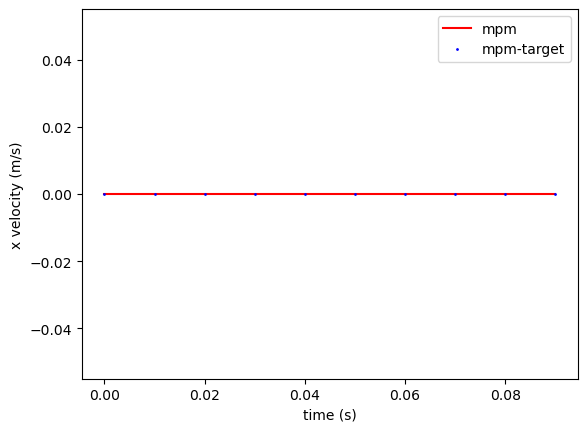

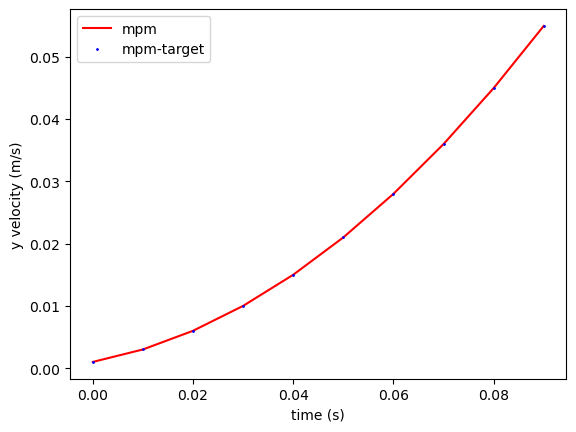

In [41]:
print("E: {}".format(result))
vel = mpm(result)
# update time steps
dt = 0.01
nsteps = 10
tt = jnp.arange(0, nsteps) * dt



# Plot results
plt.plot(tt, vel[:,0], 'r', markersize=1, label='mpm')
plt.plot(tt, target[:,0], 'ob', markersize=1, label='mpm-target')
plt.xlabel('time (s)')
plt.ylabel('x velocity (m/s)')
plt.legend()
plt.show()

plt.plot(tt, vel[:,1], 'r', markersize=1, label='mpm')
plt.plot(tt, target[:,1], 'ob', markersize=1, label='mpm-target')
plt.xlabel('time (s)')
plt.ylabel('y velocity (m/s)')
plt.legend()
plt.show()